In [1]:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, random
from sklearn.metrics import classification_report, confusion_matrix


2025-06-15 16:11:42.181381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750003902.356918      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750003902.406136      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# =============================================================
# 📂 Cell 2 – Paths, Hyper‑parameters, Data Generators
# =============================================================
base_dir   = '/kaggle/input/maize-leaf-dataset/split_dataset'  # adjust if needed
img_size   = (224, 224)   # Inception v1 TF‑Hub expects 224×224
batch_size = 32
epochs     = 20          # with transfer learning 10‑15 often suffices

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30, width_shift_range=0.15, height_shift_range=0.15,
    zoom_range=0.25, horizontal_flip=True, brightness_range=[0.7,1.3])

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size, batch_size=batch_size, class_mode='categorical')

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size, batch_size=batch_size, class_mode='categorical')

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size, batch_size=batch_size, class_mode='categorical',
    shuffle=False)


Found 4141 images belonging to 4 classes.
Found 516 images belonging to 4 classes.
Found 522 images belonging to 4 classes.


In [3]:
# =============================================================
# 🖼️ Cell 3 – (Optional) Show Random Images
# =============================================================
def show_random(folder, n=4):
    classes = [c for c in os.listdir(folder) if os.path.isdir(os.path.join(folder, c))]
    plt.figure(figsize=(15,5))
    for i in range(n):
        cls  = random.choice(classes)
        file = random.choice(os.listdir(os.path.join(folder, cls)))
        img  = load_img(os.path.join(folder, cls, file), target_size=img_size)
        plt.subplot(1,n,i+1); plt.imshow(img); plt.title(cls); plt.axis('off')
    plt.tight_layout(); plt.show()

# Uncomment to preview
# show_random(os.path.join(base_dir, 'train'))


I0000 00:00:1750003919.652786      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "InceptionScratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 192)    │        110,784 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 28, 28, 192)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 96)     │         18,528 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 16)     │          3,088 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 192)    │              0 │ max_pooling2d_1[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 64)     │         12,352 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 128)    │        110,720 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 32)     │         12,832 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 28, 28, 32)     │          6,176 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ incep_3a (Concatenate)    │ (None, 28, 28, 256)    │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 28, 28, 128)    │         32,896 │ incep_3a[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 28, 28, 32)     │          8,224 │ incep_3a[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 6,236,980 (23.79 MB)

 Trainable params: 6,236,980 (23.79 MB)

 Non-trainable params: 0 (0.00 B)

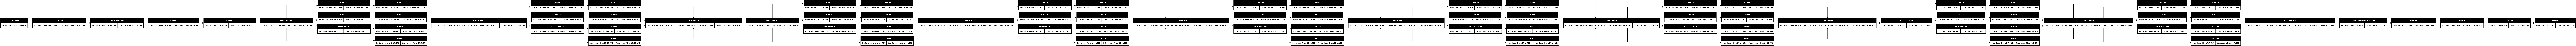

In [4]:
# =============================================================
# 🧠 Cell 4 – Build Inception v1 Transfer‑Learning Model
# =============================================================
# =============================================================
# 🧱 Cell 4 – Build Inception (GoogLeNet‑style) from Scratch
# =============================================================
def inception_module(x, f1, f3r, f3, f5r, f5, pool_proj, name=None):
    conv1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)

    conv3 = layers.Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f3, (3,3), padding='same', activation='relu')(conv3)

    conv5 = layers.Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(f5, (5,5), padding='same', activation='relu')(conv5)

    pool = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
    pool = layers.Conv2D(pool_proj, (1,1), padding='same', activation='relu')(pool)

    out = layers.concatenate([conv1, conv3, conv5, pool], axis=-1, name=name)
    return out

inputs = layers.Input(shape=img_size + (3,))

# Stem
x = layers.Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(inputs)
x = layers.MaxPool2D((3,3), strides=2, padding='same')(x)
x = layers.Conv2D(64, (1,1), activation='relu')(x)
x = layers.Conv2D(192,(3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D((3,3), strides=2, padding='same')(x)

# Inception stack (smaller than original to fit GPU memory)
x = inception_module(x,  64,  96, 128, 16, 32, 32, name='incep_3a')
x = inception_module(x, 128, 128, 192, 32, 96, 64, name='incep_3b')
x = layers.MaxPool2D((3,3), strides=2, padding='same')(x)

x = inception_module(x, 192,  96, 208, 16, 48, 64, name='incep_4a')
x = inception_module(x, 160, 112, 224, 24, 64, 64, name='incep_4b')
x = inception_module(x, 128, 128, 256, 24, 64, 64, name='incep_4c')
x = inception_module(x, 112, 144, 288, 32, 64, 64, name='incep_4d')
x = inception_module(x, 256, 160, 320, 32, 128,128, name='incep_4e')
x = layers.MaxPool2D((3,3), strides=2, padding='same')(x)

x = inception_module(x, 256, 160, 320, 32,128,128, name='incep_5a')
x = inception_module(x, 384, 192, 384, 48,128,128, name='incep_5b')


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(train_gen.num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs, name='InceptionScratch')

model.compile(optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='inception_scratch_arch.png',
           show_shapes=True, rankdir='LR')



In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1750003945.331469     118 service.cc:148] XLA service 0x78fd58259ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750003945.332314     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750003947.789905     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/130 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.2344 - loss: 1.3859    

I0000 00:00:1750003966.720928     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 144s 782ms/step - accuracy: 0.3556 - loss: 1.2897 - val_accuracy: 0.6202 - val_loss: 0.9491 - learning_rate: 1.0000e-04
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 430ms/step - accuracy: 0.6007 - loss: 0.7990 - val_accuracy: 0.6705 - val_loss: 0.7678 - learning_rate: 1.0000e-04
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 429ms/step - accuracy: 0.6968 - loss: 0.6111 - val_accuracy: 0.7481 - val_loss: 0.4964 - learning_rate: 1.0000e-04
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 432ms/step - accuracy: 0.7415 - loss: 0.5065 - val_accuracy: 0.7442 - val_loss: 0.5136 - learning_rate: 1.0000e-04
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 424ms/step - accuracy: 0.7314 - loss: 0.4900 - val_accuracy: 0.7597 - val_loss: 0.4637 - learning_rate: 1.0000e-04
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 428ms/step - accuracy: 0.7513 - loss: 0.4805 - val_accuracy: 0.7578 - val_loss: 0.4748 - learning_rate: 1.0000e-04
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 433ms/step -

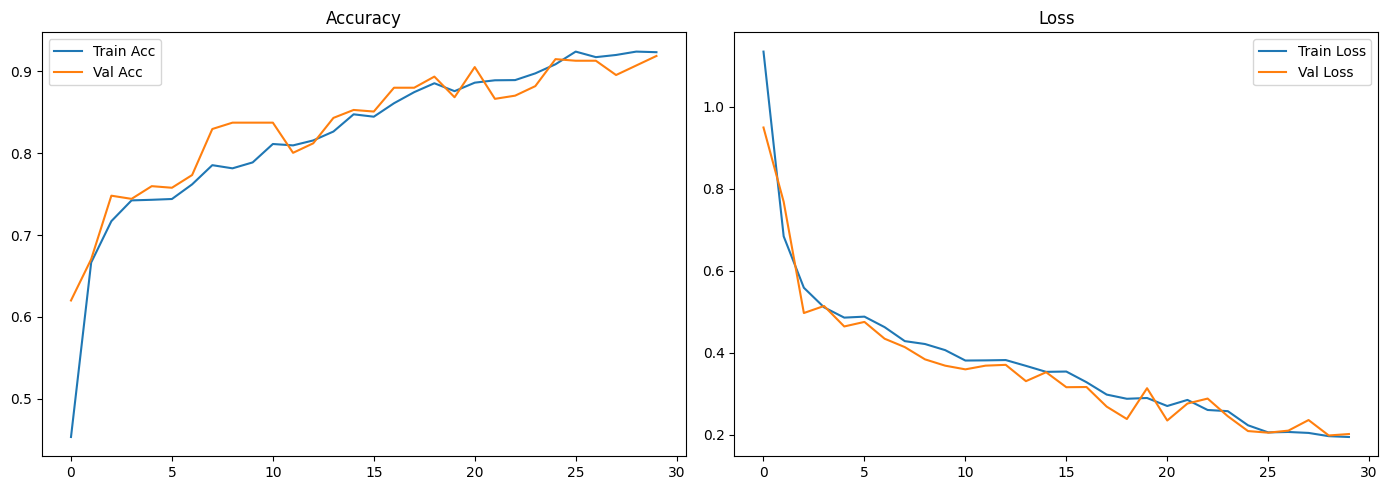

In [6]:
# =============================================================
# 📈 Cell 6 – Plot Accuracy & Loss Curves
# =============================================================
def plot_history(hist):
    plt.figure(figsize=(14,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy'); plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Loss'); plt.legend()
    plt.tight_layout(); plt.show()

plot_history(history)


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 513ms/step


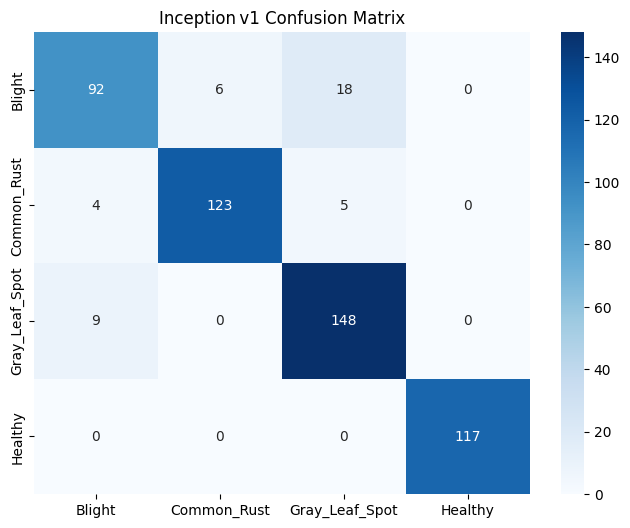

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       116
           1       0.95      0.93      0.94       132
           2       0.87      0.94      0.90       157
           3       1.00      1.00      1.00       117

    accuracy                           0.92       522
   macro avg       0.92      0.92      0.92       522
weighted avg       0.92      0.92      0.92       522



In [7]:
# =============================================================
# 🧮 Cell 7 – Evaluate & Confusion Matrix
# =============================================================
y_pred = model.predict(test_gen)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred_cls)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices,
            yticklabels=test_gen.class_indices)
plt.title('Inception v1 Confusion Matrix'); plt.show()

print(classification_report(y_true, y_pred_cls))


In [8]:
# =============================================================
# ✅ Cell 8 – Final Train / Val / Test Accuracy
# =============================================================
print(f"Final Training Accuracy   : {history.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy : {history.history['val_accuracy'][-1]*100:.2f}%")
loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy             : {test_acc*100:.2f}%")


Final Training Accuracy   : 92.32%
Final Validation Accuracy : 91.86%
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.8576 - loss: 0.3339
Test Accuracy             : 91.95%



Class: Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


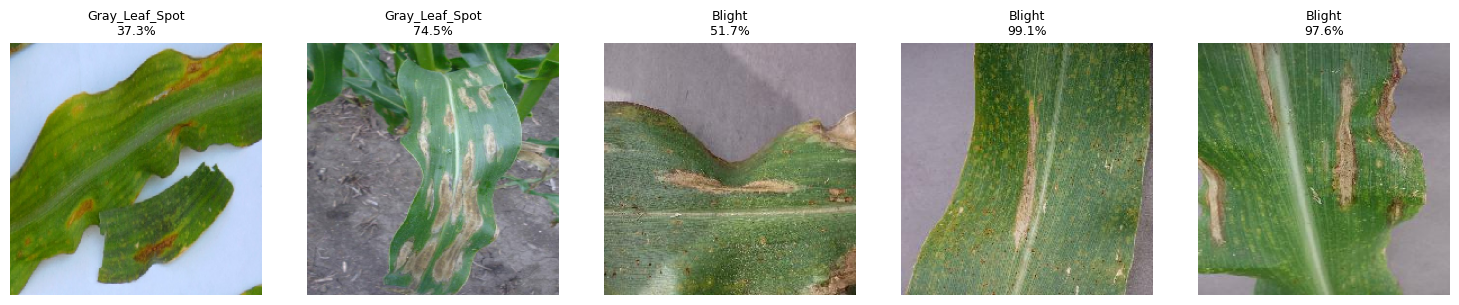


Class: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


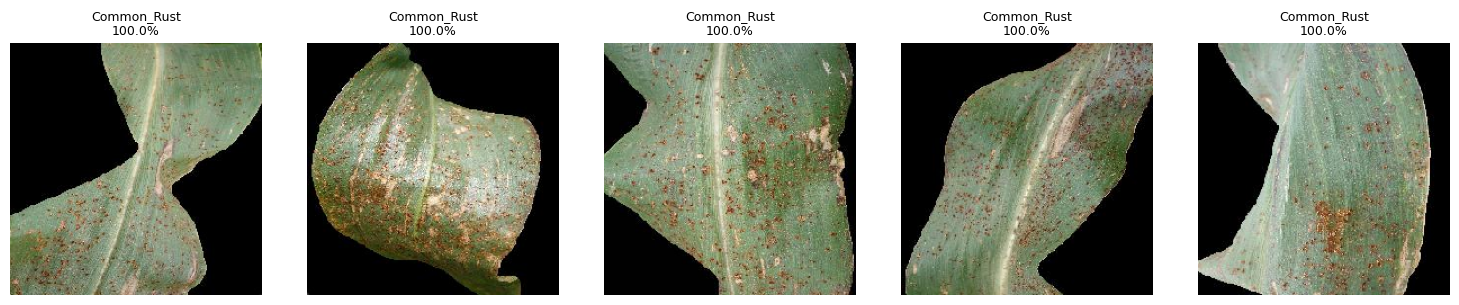


Class: Gray_Leaf_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


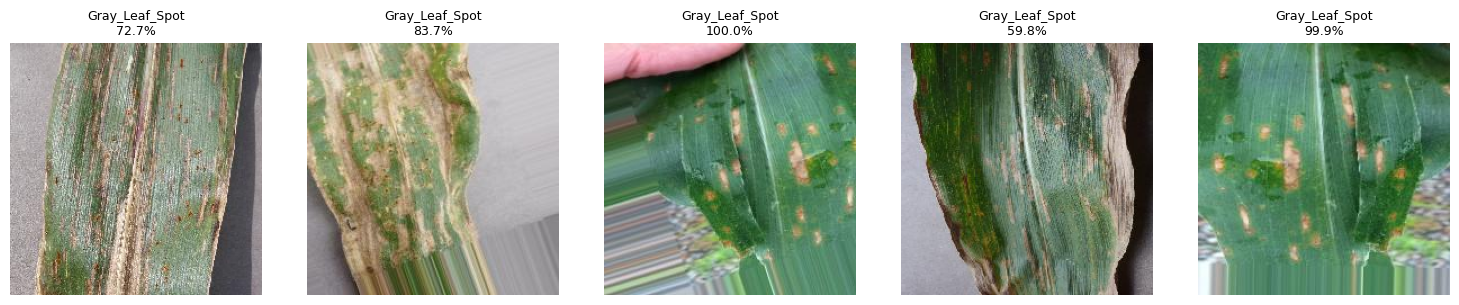


Class: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


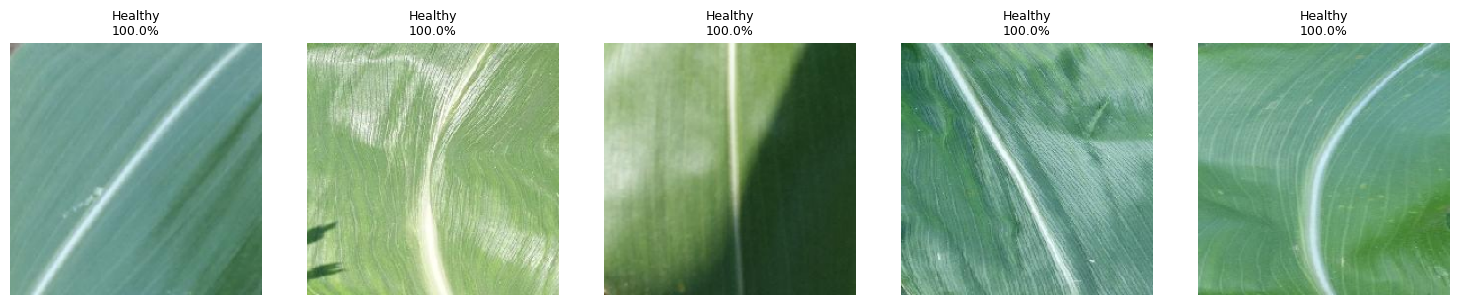

In [9]:
# =============================================================
# 🔍 Cell 9 – Random Predictions on Test Images
# =============================================================
test_dir = os.path.join(base_dir, 'test')
class_names = sorted(os.listdir(test_dir))

for cls in class_names:
    cls_path = os.path.join(test_dir, cls)
    img_files = [f for f in os.listdir(cls_path)
                 if f.lower().endswith(('jpg','jpeg','png'))]
    sample_imgs = random.sample(img_files, 5)
    print(f"\nClass: {cls}")
    plt.figure(figsize=(15,3))
    for i, file in enumerate(sample_imgs):
        path = os.path.join(cls_path, file)
        img  = load_img(path, target_size=img_size)
        arr  = img_to_array(img)/255.0
        pred = model.predict(np.expand_dims(arr, 0))
        pred_cls = class_names[np.argmax(pred)]
        conf = np.max(pred)*100
        plt.subplot(1,5,i+1)
        plt.imshow(img); plt.axis('off')
        plt.title(f'{pred_cls}\n{conf:.1f}%', fontsize=9)
    plt.tight_layout(); plt.show()
